**Final Set-up**

In [ ]:
# The data is coming from our shared drive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import joblib
import re
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load and Prepare Data**

In [ ]:
# Load the dataset
!ls "/content/drive/Shared drives/CSI 5130/SemEval2018-Task1-all-data/Spanish/E-c/trainn.txt"


# Define emotions
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
            'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Load Data
try:
    df = pd.read_csv(
        '/content/drive/Shared drives/CSI 5130/SemEval2018-Task1-all-data/Spanish/E-c/trainn.txt',
        sep='\t',
        header=0,
        dtype={'ID': str, 'Tweet': str, **{e: int for e in emotions}}
    )
except Exception as e:
    raise

# Initial Emotion Counts
print("\nInitial label counts:")
print(df[emotions].sum())

'/content/drive/Shared drives/CSI 5130/SemEval2018-Task1-all-data/Spanish/E-c/trainn.txt'

Initial label counts:
anger           1155
anticipation     415
disgust          521
fear             373
joy             1085
love             260
optimism         377
pessimism        578
sadness          845
surprise         169
trust            175
dtype: int64


**Clean and Preprocess Data**

In [ ]:
# Clean the tweets and preprocess the data

def clean_tweet(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

df['clean_tweet'] = df['Tweet'].apply(clean_tweet)

trust_upsample = df[df['trust'] == 1]
surprise_upsample = df[df['surprise'] == 1]

# Oversampling the rare emotions
df = pd.concat([
    df,
    trust_upsample,
    trust_upsample,
    trust_upsample,
    trust_upsample,
    trust_upsample,
    surprise_upsample,
    surprise_upsample,
    surprise_upsample,
    surprise_upsample,
    surprise_upsample
], ignore_index=True)


df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify labels
print("\nLabel verification before splitting:")
print("Data types:", df[emotions].dtypes)
print("Label counts:")
print(df[emotions].sum())

# Handle any non-numeric values
for emotion in emotions:
    if df[emotion].dtype == object:
        print(f"\nConverting {emotion} column...")
        df[emotion] = pd.to_numeric(df[emotion], errors='coerce').fillna(0).astype(int)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(
    df['clean_tweet'],
    df[emotions],
    test_size=0.2,
    random_state=42
)


# Convert to numpy arrays
Y_train_values = Y_train.astype('float32').values
Y_test_values = Y_test.astype('float32').values


Label verification before splitting:
Data types: anger           int64
anticipation    int64
disgust         int64
fear            int64
joy             int64
love            int64
optimism        int64
pessimism       int64
sadness         int64
surprise        int64
trust           int64
dtype: object
Label counts:
anger           1415
anticipation     740
disgust          611
fear             498
joy             1700
love             395
optimism         737
pessimism        698
sadness         1015
surprise        1049
trust           1085
dtype: int64


**Verify Data**

In [ ]:
# Clean the tweets using preprocessing functions
print("Label balance in full dataset:")
print(df[emotions].sum())

print("\nSample of labels and text:")
print(df[['clean_tweet'] + emotions].head(3))

Label balance in full dataset:
anger           1415
anticipation     740
disgust          611
fear             498
joy             1700
love             395
optimism         737
pessimism        698
sadness         1015
surprise        1049
trust           1085
dtype: int64

Sample of labels and text:
                                         clean_tweet  anger  anticipation  \
0    para tristeza y felicidad ed sheeran al rescate      0             0   
1                                          y tú a mi      0             0   
2  magui siempre pensando en comer vos jajajaja p...      0             0   

   disgust  fear  joy  love  optimism  pessimism  sadness  surprise  trust  
0        0     0    1     0         0          0        1         0      0  
1        0     0    0     0         0          0        0         0      0  
2        1     0    1     0         0          0        0         0      0  


**Tokenize and Pad Sequences**

In [ ]:
# Tokenize & Pad the Tweets

# Set tokenizer
vocab_size = 10000
max_length = 50
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

**Build CNN Model**

In [ ]:
# CNN model
max_len = X_train_pad.shape[1]
num_classes = Y_train_values.shape[1]

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Dropout(0.3),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')
])

optimizer = Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc_1')]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Add Class Weighting**

In [ ]:
# Calculate weights per emotion
class_weights = {}
for i, emotion in enumerate(emotions):
    weights = compute_class_weight(
        'balanced',
        classes=np.unique(Y_train_values[:, i]),
        y=Y_train_values[:, i]
    )
    class_weights[i] = weights[1] if len(weights) > 1 else 1.0

print("Class weights:", class_weights)

Class weights: {0: np.float64(1.8652826855123674), 1: np.float64(3.5727580372250425), 2: np.float64(4.231462925851703), 3: np.float64(5.162591687041565), 4: np.float64(1.5537159676232524), 5: np.float64(6.724522292993631), 6: np.float64(3.536850921273032), 7: np.float64(3.860146252285192), 8: np.float64(2.6100123609394315), 9: np.float64(2.5287425149700598), 10: np.float64(2.4382217090069283)}


**Train Model**

In [ ]:
# Train the CNN model
history = model.fit(
    X_train_pad,
    Y_train_values,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_auc_1', mode='max', restore_best_weights=True),
        ModelCheckpoint('best_model.h5', monitor='val_auc_1', save_best_only=True, mode='max')
    ],
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0601 - auc_1: 0.4938 - loss: 1.5434

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.0607 - auc_1: 0.4942 - loss: 1.5392 - val_accuracy: 0.1702 - val_auc_1: 0.6221 - val_loss: 0.4644
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1286 - auc_1: 0.5436 - loss: 1.2711

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.1280 - auc_1: 0.5437 - loss: 1.2708 - val_accuracy: 0.0638 - val_auc_1: 0.6282 - val_loss: 0.4514
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1093 - auc_1: 0.5589 - loss: 1.2357

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.1096 - auc_1: 0.5590 - loss: 1.2355 - val_accuracy: 0.2080 - val_auc_1: 0.6697 - val_loss: 0.4524
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1325 - auc_1: 0.5868 - loss: 1.2191

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.1329 - auc_1: 0.5871 - loss: 1.2183 - val_accuracy: 0.2199 - val_auc_1: 0.7185 - val_loss: 0.4359
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1707 - auc_1: 0.6398 - loss: 1.1642

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.1712 - auc_1: 0.6403 - loss: 1.1635 - val_accuracy: 0.2293 - val_auc_1: 0.7744 - val_loss: 0.4121
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2037 - auc_1: 0.7289 - loss: 1.0778

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.2040 - auc_1: 0.7293 - loss: 1.0768 - val_accuracy: 0.2600 - val_auc_1: 0.8011 - val_loss: 0.3753
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2720 - auc_1: 0.7964 - loss: 0.9467

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.2720 - auc_1: 0.7969 - loss: 0.9464 - val_accuracy: 0.2861 - val_auc_1: 0.8313 - val_loss: 0.3413
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2902 - auc_1: 0.8550 - loss: 0.8557

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.2907 - auc_1: 0.8551 - loss: 0.8551 - val_accuracy: 0.3286 - val_auc_1: 0.8564 - val_loss: 0.3154
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3668 - auc_1: 0.8931 - loss: 0.7609

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.3669 - auc_1: 0.8932 - loss: 0.7605 - val_accuracy: 0.3570 - val_auc_1: 0.8687 - val_loss: 0.2948
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4069 - auc_1: 0.9210 - loss: 0.6758

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.4074 - auc_1: 0.9210 - loss: 0.6756 - val_accuracy: 0.4090 - val_auc_1: 0.8803 - val_loss: 0.2827
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4713 - auc_1: 0.9349 - loss: 0.6276

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.4715 - auc_1: 0.9350 - loss: 0.6269 - val_accuracy: 0.3948 - val_auc_1: 0.8829 - val_loss: 0.2740
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5128 - auc_1: 0.9501 - loss: 0.5519

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5133 - auc_1: 0.9501 - loss: 0.5517 - val_accuracy: 0.4137 - val_auc_1: 0.8875 - val_loss: 0.2643
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5384 - auc_1: 0.9565 - loss: 0.5163

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5386 - auc_1: 0.9566 - loss: 0.5159 - val_accuracy: 0.4279 - val_auc_1: 0.8948 - val_loss: 0.2557
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5619 - auc_1: 0.9668 - loss: 0.4638

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.5620 - auc_1: 0.9668 - loss: 0.4637 - val_accuracy: 0.4539 - val_auc_1: 0.8954 - val_loss: 0.2546
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5737 - auc_1: 0.9720 - loss: 0.4265

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.5736 - auc_1: 0.9720 - loss: 0.4264 - val_accuracy: 0.4563 - val_auc_1: 0.8990 - val_loss: 0.2503
Epoch 16/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5851 - auc_1: 0.9771 - loss: 0.3920

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5850 - auc_1: 0.9771 - loss: 0.3920 - val_accuracy: 0.4728 - val_auc_1: 0.9035 - val_loss: 0.2471
Epoch 17/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5866 - auc_1: 0.9795 - loss: 0.3745

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5864 - auc_1: 0.9795 - loss: 0.3744 - val_accuracy: 0.4681 - val_auc_1: 0.9056 - val_loss: 0.2463
Epoch 18/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5932 - auc_1: 0.9804 - loss: 0.3601 - val_accuracy: 0.4586 - val_auc_1: 0.9037 - val_loss: 0.2486
Epoch 19/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.5997 - auc_1: 0.9849 - loss: 0.3216 - val_accuracy: 0.4634 - val_auc_1: 0.9041 - val_loss: 0.2493
Epoch 20/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5774 - auc_1: 0.9850 - loss: 0.3159 - val_accuracy: 0.4515 - val_auc_1: 0.9028 - val_loss: 0.2551
Epoch 21/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5836 - auc_1: 0.9877 - loss: 0.2791

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.5838 - auc_1: 0.9877 - loss: 0.2794 - val_accuracy: 0.4374 - val_auc_1: 0.9065 - val_loss: 0.2516
Epoch 22/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5967 - auc_1: 0.9876 - loss: 0.2893 - val_accuracy: 0.4444 - val_auc_1: 0.9045 - val_loss: 0.2559
Epoch 23/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5895 - auc_1: 0.9894 - loss: 0.2691 - val_accuracy: 0.4752 - val_auc_1: 0.9063 - val_loss: 0.2581
Epoch 24/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.5907 - auc_1: 0.9896 - loss: 0.2697 - val_accuracy: 0.4492 - val_auc_1: 0.9057 - val_loss: 0.2596
Epoch 25/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5802 - auc_1: 0.9898 - loss: 0.2635

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.5807 - auc_1: 0.9898 - loss: 0.2632 - val_accuracy: 0.4397 - val_auc_1: 0.9084 - val_loss: 0.2533
Epoch 26/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6124 - auc_1: 0.9911 - loss: 0.2445 - val_accuracy: 0.4066 - val_auc_1: 0.9042 - val_loss: 0.2675
Epoch 27/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5846 - auc_1: 0.9921 - loss: 0.2262 - val_accuracy: 0.4799 - val_auc_1: 0.9038 - val_loss: 0.2684
Epoch 28/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6066 - auc_1: 0.9920 - loss: 0.2277 - val_accuracy: 0.4634 - val_auc_1: 0.9039 - val_loss: 0.2740
Epoch 29/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5883 - auc_1: 0.9928 - loss: 0.2191 - val_accuracy: 0.4303 - val_auc_1: 0.9010 - val_loss: 0.2770
Epoch 30/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5982 - auc_1: 0.9931 - loss: 0.2129 - val_accuracy: 0.4184 - val_auc_1: 0.9054 - val_loss: 0.2709


**Save Tokenizer**

In [ ]:

with open('spanishTokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


from google.colab import files
files.download('spanishTokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Save Model**

In [ ]:
# Save CNN model
model.save("spanish_model.keras", include_optimizer=False)
!zip -r spanish_model.zip spanish_model.keras

# Download CNN model
from google.colab import files
files.download("spanish_model.zip")

  adding: spanish_model.keras (deflated 24%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Evaluate Performace**

In [ ]:
# Get predictions
pred_probs = model.predict(X_test_pad)
pred_labels = (pred_probs >= 0.3).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(Y_test_values, pred_labels, target_names=emotions, zero_division=0))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.64      0.64      0.64       283
anticipation       0.64      0.60      0.62       149
     disgust       0.44      0.55      0.49       112
        fear       0.69      0.65      0.67        89
         joy       0.81      0.75      0.78       341
        love       0.77      0.57      0.65        81
    optimism       0.74      0.65      0.69       140
   pessimism       0.50      0.50      0.50       151
     sadness       0.62      0.73      0.67       206
    surprise       0.90      1.00      0.95       214
       trust       0.87      1.00      0.93       219

   micro avg       0.71      0.73      0.72      1985
   macro avg       0.69      0.69      0.69      1985
weighted avg       0.71      0.73      0.72      1985
 samples avg       0.67      0.68      0.66      1985



**Bar Graph**

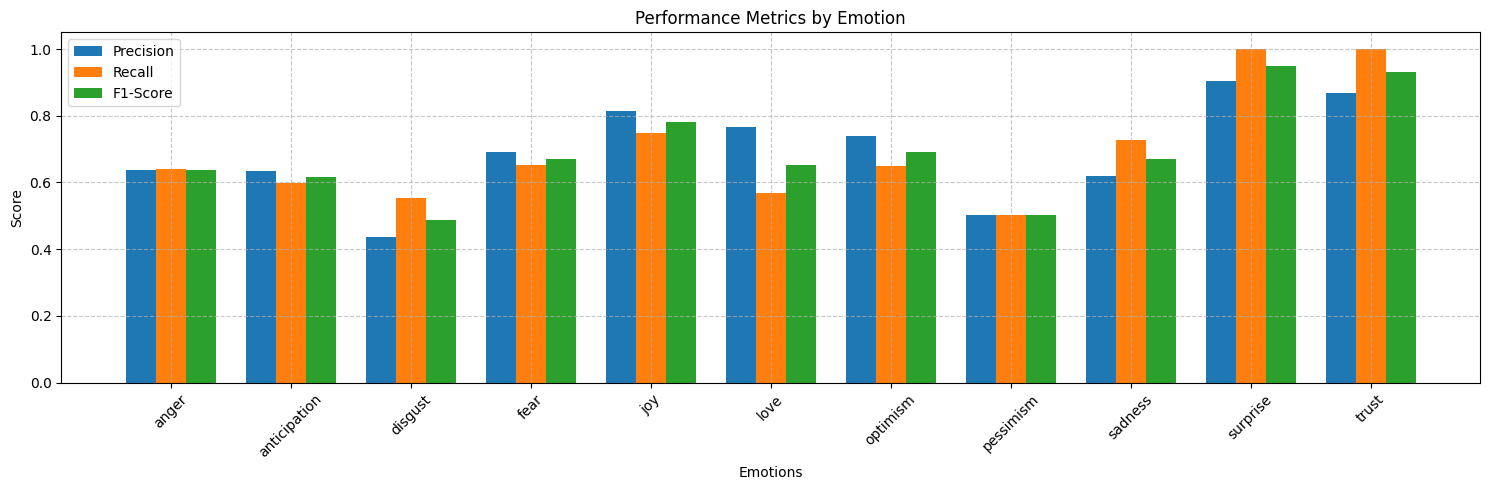

In [ ]:
#Metrics for each emotion
metrics = {
    'Precision': precision_score(Y_test_values, pred_labels, average=None),
    'Recall': recall_score(Y_test_values, pred_labels, average=None),
    'F1-Score': f1_score(Y_test_values, pred_labels, average=None)
}

# Plot graph
plt.figure(figsize=(15, 5))
x = np.arange(len(emotions))
width = 0.25

for i, (metric_name, values) in enumerate(metrics.items()):
    plt.bar(x + i*width, values, width, label=metric_name)

plt.xlabel('Emotions')
plt.ylabel('Score')
plt.title('Performance Metrics by Emotion')
plt.xticks(x + width, emotions, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Confusion Matrices**

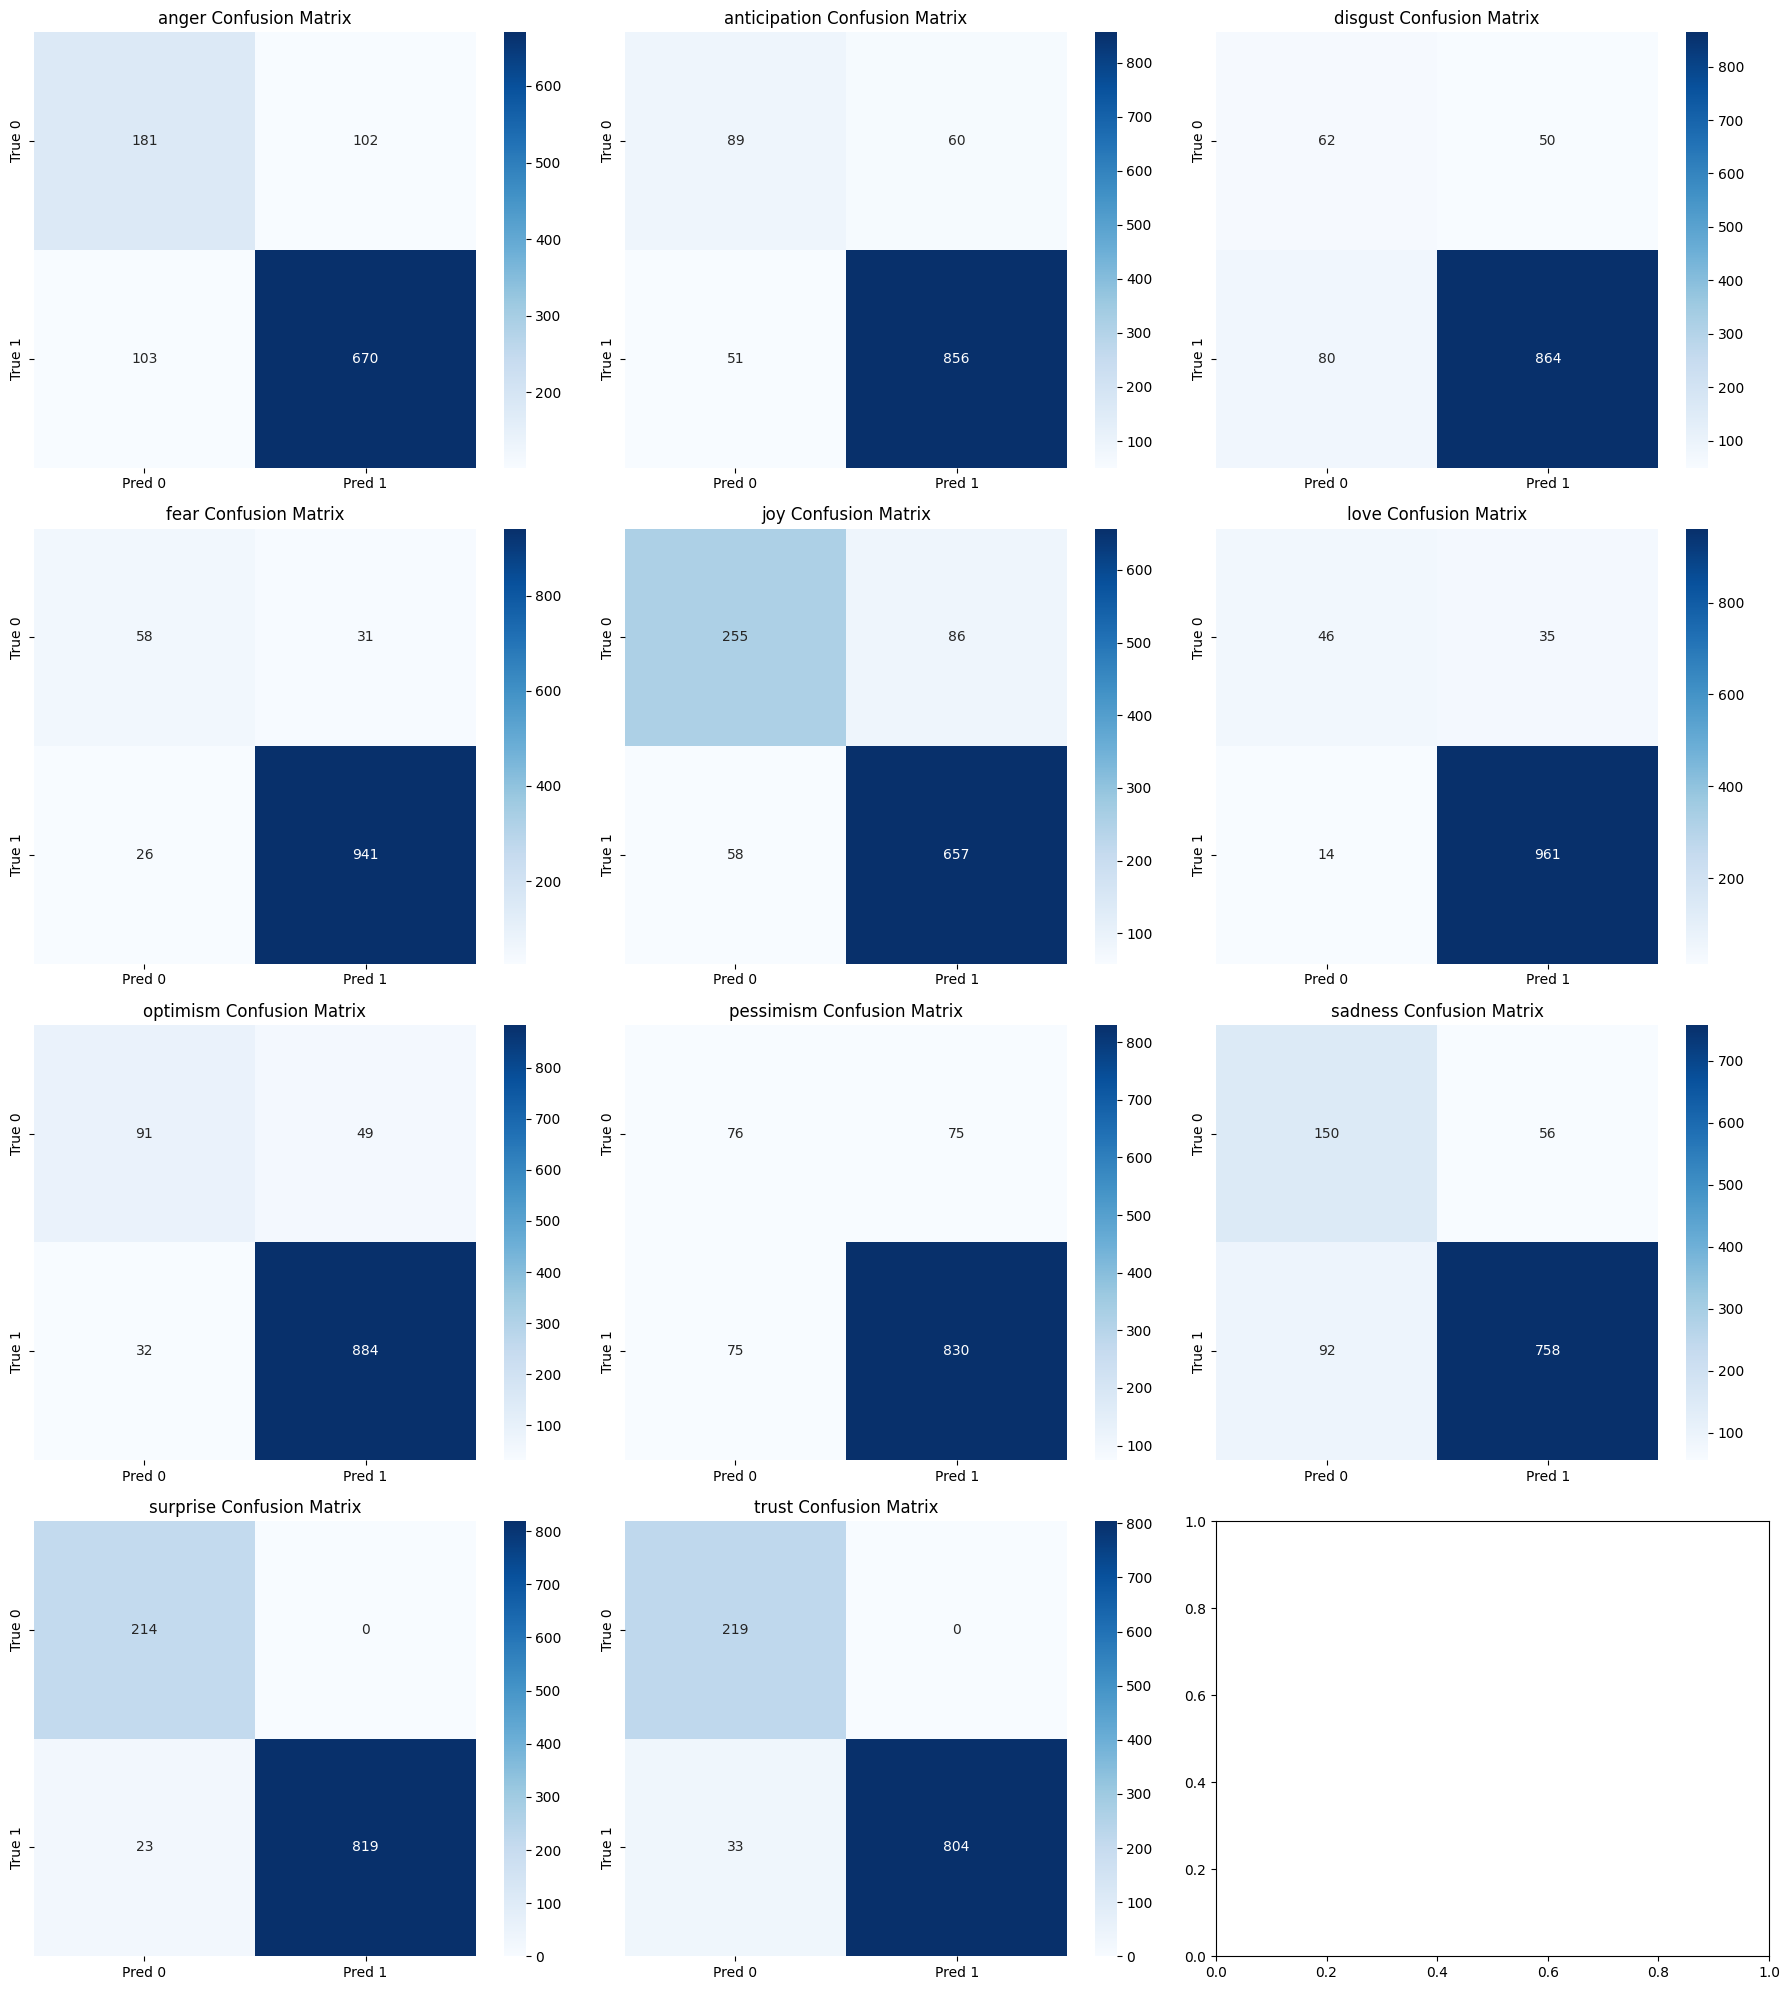

In [ ]:
#Grid of confusion matrices
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.ravel()

for i, emotion in enumerate(emotions):
    cm = multilabel_confusion_matrix(Y_test_values[:,i], pred_labels[:,i])[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    axes[i].set_title(f'{emotion} Confusion Matrix')

plt.tight_layout()
plt.show()

**Sample Predictions**

In [ ]:
# Sample Predictions
sample_idx = np.random.choice(len(X_test), 5, replace=False)
for idx in sample_idx:
    print(f"Tweet: {X_test.iloc[idx]}")
    print("True Labels:", [emotions[i] for i, val in enumerate(Y_test_values[idx]) if val == 1])
    print("Predicted Labels:", [emotions[i] for i, val in enumerate(pred_labels[idx]) if val == 1])
    print("---")

Tweet: soy terrible yeta por la chucha por qué nací así
True Labels: ['anger', 'pessimism']
Predicted Labels: ['anger', 'disgust']
---
Tweet: jajajajaja me paso lo mismo hoy culpa de la tormenta obvio
True Labels: ['joy']
Predicted Labels: ['joy']
---
Tweet: lo peor es que ella habla como si en católica te preguntaran nombres de autores y cosas así por ser literatura es tan gracioso
True Labels: ['joy']
Predicted Labels: ['anger', 'disgust']
---
Tweet: kheeee no saben tus señores padres
True Labels: ['sadness', 'surprise']
Predicted Labels: ['sadness', 'surprise']
---
Tweet: he aprendido a ser menos egoísta y más tragon gracias a ti así que cuenta conmigo para todo
True Labels: ['joy', 'trust']
Predicted Labels: ['joy', 'trust']
---
